# Wrangle OpenStreetMap Data

# Project Overview

From https://www.openstreetmap.org I choose my hometown of Round Hill, VA. Very small town west of VA.

Goals:

- Assess the quality of the data for validity, accuracy, completeness, consistency and uniformity.
- Parse and gather data from popular file formats such as .csv, .json, .xml, and .html
- Process data from multiple files or very large files that can be cleaned programmatically.
- Store, query, and aggregate data using SQL.

Map Area
Round Hill, VA, United States

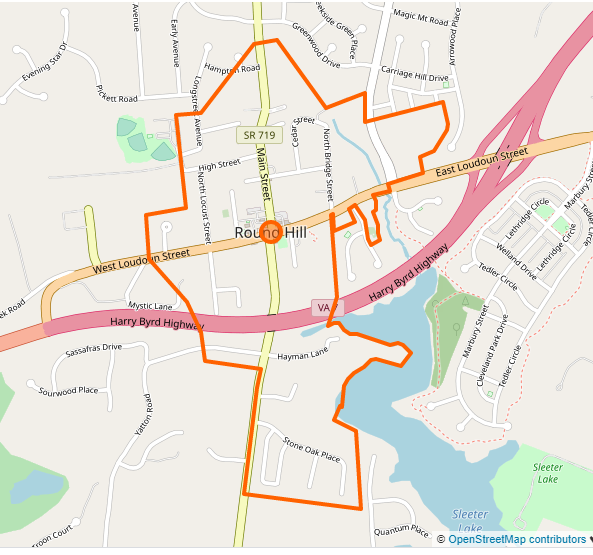

https://www.openstreetmap.org/relation/206880

First I looked at XML elements (nodes,way points, relation) information I found here: https://wiki.openstreetmap.org/wiki/OSM_XML

# Node:
Nodes are individual dots used to mark specific locations. See example below:

# Way point 
Ways are used to create roads, paths, rivers, etc. See example below:

# Relation 
Relations are used to create map features, such as cycling routes, turn restrictions and areas that are not contiguous. See example below:

Looking through my OSM File I see some outstanding issues
# Problems:

# Goal #1

- Assess the quality of the data for validity, accuracy, completeness, consistency and uniformity.

**Data Exploration and Cleaning**

In [190]:
import os
os.getcwd()

'C:\\Wrangle OpenStreetMap Data'

In [191]:
os.chdir("C:\Wrangle OpenStreetMap Data")
os.getcwd()

'C:\\Wrangle OpenStreetMap Data'

In [192]:
#Importing modules
import xml.etree.ElementTree as ET
from collections import defaultdict
import re
import pprint
import csv
import codecs

**Get SAMPLE FILE** 

Using the provided 'OSM_sampling.py'

In [193]:
#Import osm file and create sample dataset

#!/usr/bin/env python
# -*- coding: utf-8 -*-

OSM_FILE = "mapRH.osm"
OSMFILE = "sample.osm"

k = 10 # Parameter: take every k-th top level element

def get_element(osm_file, tags=('node', 'way', 'relation')):
    context = iter(ET.iterparse(osm_file, events=('start', 'end')))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()

            
with open(OSMFILE, 'w', encoding='utf8') as output:
    output.write('<?xml version="1.0" encoding="UTF-8"?>\n')
    output.write('<osm>\n  ')
    # Write every kth top level element
    for i, element in enumerate(get_element(OSM_FILE)):
        if i % k == 0:
            output.write(ET.tostring(element, encoding='unicode'))
    output.write('</osm>')


Now I will get a **count the unique element types.**

In [194]:
def count_tags(filename):
    tags = {}
    for event, elem in ET.iterparse(filename, events=('start', )):
        if elem.tag not in tags:
            tags[elem.tag] = 1
        else:
            tags[elem.tag] += 1
    return tags

def test():

    tags = count_tags('sample.osm')
    pprint.pprint(tags)
    

if __name__ == "__main__":
    test()

{'member': 733,
 'nd': 800,
 'node': 554,
 'osm': 1,
 'relation': 1,
 'tag': 212,
 'way': 43}


Next lets **check the "k" values**

Getting a count of each of the tag categories in a dictionary.

In [195]:
lower = re.compile(r'^([0-9a-z]|_)*$') #valid tags that contain only lowercase letters 
lower_colon = re.compile(r'^([a-z]|_)*:([0-9a-z]|_|-)*$') #valid lowercase letter tags with a colon in their names
upper = re.compile(r'^([A-Z]|_)*$') #valid tags that contain only uppercase letters
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]') #tags with problematic characters


def key_type(element, keys):
    if element.tag == "tag":
        if lower.search(element.attrib['k']):
            keys['lower'] += 1
            # print('lower: ' + element.attrib['k'])
        elif lower_colon.search(element.attrib['k']):
            keys['lower_colon'] += 1
            # print('lower_col: ' + element.attrib['k'])
        elif upper.search(element.attrib['k']):
            keys['upper'] += 1
            # print('upper: ' + element.attrib['k'])
        elif problemchars.search(element.attrib['k']):
            keys['problemchars'] += 1
            # print('prob: ' + element.attrib['k'])
        else:
            # print('other--  ' + element.attrib['k'])
            keys['other'] += 1
    return keys



def process_map(filename):
    keys = {"lower": 0, "lower_colon": 0, "upper":0, "problemchars": 0, "other": 0}
    for _, element in ET.iterparse(filename):
        keys = key_type(element, keys)

    return keys


if __name__ == "__main__":
    pm = process_map('sample.osm')
    pprint.pprint(pm)

{'lower': 130, 'lower_colon': 82, 'other': 0, 'problemchars': 0, 'upper': 0}


**Unique Users**

Next lets look into the users. I will now see how many unique users have contributed to the data.

In [196]:
def get_user(element):
    return


def process_map(filename):
    users = set()
    for _, element in ET.iterparse(filename):
        try:
            users.add(element.attrib['uid'])
        except KeyError:
            continue

    return users


def test():

    users = process_map('sample.osm')
    pprint.pprint(len(users))

if __name__ == "__main__":
    test()


108


**Checking the validity and consistency**

Lets take a look at the street names next

In [197]:
OSMFILE = "sample.osm"
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)


expected = ["Road", "Street", "Drive", "Highway", "Court", "Lane", "Avenue", "Circle", "Place", "Mountain", 
            "Square", "Terrace", "North", "East", "Alley", "West", "Lake"]


def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)

def print_sorted_dic(d):
    keys = d.keys()
    keys = sorted(keys, key=lambda s: s.lower())
    for k in keys:
        v = d[k]
        print("%s: %d" % (k, v))

def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")


def audit():
#    osm_file = open(osmfile, "r")
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(OSMFILE, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    pprint.pprint(dict(street_types))

if __name__ == '__main__':
    audit()

{}


No problems here, ...maybe!**???**

In [198]:
OSMFILE = "sample.osm"

mapping = { "St": "Street",
            "street": "Street",
            "Rd" : "Road",
            "road" : "Road",
            "Dr" : "Drive",
            "Hwy" : "Highway",
            "Ct" : "Court",
            "Ln" : "Lane",
            "Ave" : "Avenue",
            "Cir" : "Circle",
            "Pl" : "Place",
            "Mt" : "Mountain",
            "Sq" : "Square",
            "Ter": "Terrace",
            "N": "North",
            "E" : "East",
            "alley" : "Alley",
            "W" : "West",
            "lake": "Lake"
          }

def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)


def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")


def audit(osmfile):
    osm_file = open(osmfile, "r")
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(osmfile, events=("start",)):

        if elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    osm_file.close()
    return street_types


def update_name(name, mapping):
    for key, value in mapping.items():
        if re.search(key, name):
            name = re.sub(street_type_re, value, name)

    return name


def test():
    st_types = audit(OSMFILE)
    for st_type, ways in st_types.items():
        for name in ways:
            better_name = update_name(name, mapping)
            print (name, "=>", better_name)


if __name__ == '__main__':
    test()

No problems here, ...maybe!**???**

**Checking zip codes**

In [199]:
# Here we create a dictionary of our postal codes
def audit_postal_code(postal_code_types, postal_code):  
    if not postal_code.isupper() or ' ' not in postal_code:
        postal_code_types['Postal Codes'].add(postal_code)
    else:
        postal_code_types['other'].add(postal_code)
    return postal_code_types

def is_postal_code(elem):
    return (elem.attrib['k'] == "addr:postcode")

def audit(filename):
    f = (filename)
    postal_code_types = defaultdict(set)
    
    for event, element in ET.iterparse(f, events=("start",)):
        if element.tag =="way":
            for tag in element.iter("tag"):
                if is_postal_code(tag):
                    audit_postal_code(postal_code_types, tag.attrib['v'])
    print(dict(postal_code_types))

if __name__ == '__main__':
    audit(OSMFILE)

{'Postal Codes': {'20141'}}


In [200]:
OSMFILE = "sample.osm"
postal_code_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)


expected = ["20141"]


def audit_postal_code(postal_code_types, postal_codes):
    m = postal_code_type_re.search(postal_codes)
    if m:
        postal_code = m.group()
        if postal_code not in expected:
            postal_code_types[postal_code].add(postal_code)

def is_postal_code(elem):
    return (elem.attrib['k'] == "addr:postcode")


def audit():
    postal_codes = defaultdict(set)
    for event, elem in ET.iterparse(OSMFILE, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_postal_code(tag):
                    audit_postal_code(postal_codes, tag.attrib['v'])
    
    print("Postal codes in data set that are not in Round Hill")
    pprint.pprint(dict(postal_codes))

if __name__ == '__main__':
    audit()

Postal codes in data set that are not in Round Hill
{}


**Unique Keys**

In [201]:
def unique_keys(filename):
    distinct_keys=[]
    count=1

    EL=get_element(filename, tags=('node', 'way', 'relation'))
    for element in EL:
        if element.tag=='node' or element.tag=='way':
            for tag in element.iter('tag'):
                if tag.attrib['k'] not in distinct_keys:
                    distinct_keys.append(tag.attrib['k'])
                    count+=1
    distinct_keys.sort()
    print("Total number of unique keys (tag attrib['k'])is {}:".format(count))
    
#    return distinct_keys
    pprint.pprint(distinct_keys)
    
unique_keys(OSMFILE)  

Total number of unique keys (tag attrib['k'])is 51:
['access',
 'addr:city',
 'addr:housenumber',
 'addr:postcode',
 'addr:state',
 'addr:street',
 'amenity',
 'barrier',
 'building',
 'created_by',
 'denomination',
 'destination',
 'destination:ref',
 'ele',
 'gnis:county_name',
 'gnis:feature_id',
 'gnis:import_uuid',
 'gnis:reviewed',
 'highway',
 'intermittent',
 'landuse',
 'leisure',
 'maxspeed',
 'name',
 'name_1',
 'natural',
 'oneway',
 'ref',
 'religion',
 'salt',
 'service',
 'shop',
 'source',
 'sport',
 'surface',
 'tidal',
 'tiger:cfcc',
 'tiger:county',
 'tiger:name_base',
 'tiger:name_base_1',
 'tiger:name_direction_prefix',
 'tiger:name_type',
 'tiger:reviewed',
 'tiger:separated',
 'tiger:source',
 'tiger:tlid',
 'tiger:upload_uuid',
 'tiger:zip_left',
 'tiger:zip_right',
 'water']


**Auditing the street names**

In [202]:
# run in Python 3

OSMFILE = 'sample.osm'

street_type_re = re.compile('pattern, re.VERBOSE')


# I- count occurences for each street type
def count_street_type(street_type_count, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        street_type_count[street_type] +=1
    else:
        street_type_count[street_name] +=1


# II- group streets by type
def group_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        street_types[street_type].add(street_name)
    else:
        street_types[street_name].add(street_name)

# sorts the count of street types in descending order
def sort_values(street_type_count):
    sorted_counts = []
    d_view = [(v,k) for k,v in street_type_count.items()]
    d_view.sort(reverse=True) # natively sort tuples by first element
    for v,k in d_view:
        sorted_counts.append("%s: %d" % (k,v))
    return sorted_counts


def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")

# perform all of the above audits on the file
def audit(osmfile):
    osm_file = open(osmfile, "r")

    street_type_count = defaultdict(int)
    street_types = defaultdict(set)
    
    for event, elem in ET.iterparse(osm_file, events=("start",)):

        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    count_street_type(street_type_count, tag.attrib['v'])
                    group_street_type(street_types, tag.attrib['v'])
                
    osm_file.close()

    street_type_count = sort_values(street_type_count)

    return street_type_count, street_types


pprint.pprint(audit(OSMFILE))

(['East Loudoun Street: 1'],
 defaultdict(<class 'set'>, {'East Loudoun Street': {'East Loudoun Street'}}))


Checking on **state names**

In [203]:
def is_state(elem):
    return (elem.attrib['k'] == "addr:state")

state_types = defaultdict(int)

def audit_state(state_types, state_name):
    if state_name != 'VA':
        state_types[state_name] += 1
        print(state_name)

for event, elem in ET.iterparse(OSMFILE, events =("start",)):
    if elem.tag == "node" or elem.tag == "way":
        for tag in elem.iter("tag"):
            if is_state(tag):
                audit_state(state_types, tag.attrib['v'])

And lastly **phone numbers**

In [204]:
def is_phone(elem):
    return (elem.attrib['k'] == "phone" or elem.attrib['k'] == "contact:phone")

def audit_phone_number_formats(phone_number_formats, phone_number):

    # Convert any digit to an 'X' sign (e.g. '(212) 333-3100' becomes '(XXX) XXX-XXXX')
    phone_number_format = re.sub('\d', 'X', phone_number)
    phone_number_formats[phone_number_format] += 1

def audit(osmfile):
    osmfile = OSMFILE
    phone_number_formats = defaultdict(int)
    for event, elem in ET.iterparse(osmfile, events=('start',)):

        if elem.tag == 'node' or elem.tag == 'way':
            for tag in elem.iter('tag'):
                # Audit phone numbers
                if is_phone(tag):
                    audit_phone_number_formats(phone_number_formats, tag.attrib['v'])
    pprint.pprint(dict(phone_number_formats))

audit(OSMFILE)

{}


One last cleap up of the dataset

In [205]:
OSM_FILE = "mapRH.osm"
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)


expected = ["Road", "Street", "Drive", "Highway", "Court", "Lane", "Avenue", "Circle", "Place", "Mountain", 
            "Square", "Terrace", "North", "East", "Alley", "West", "Lake"]

mapping = { "St": "Street",
            "street": "Street",
            "Rd" : "Road",
            "road" : "Road",
            "Dr" : "Drive",
            "Hwy" : "Highway",
            "Ct" : "Court",
            "Ln" : "Lane",
            "Ave" : "Avenue",
            "Cir" : "Circle",
            "Pl" : "Place",
            "Mt" : "Mountain",
            "Sq" : "Square",
            "Ter": "Terrace",
            "N": "North",
            "E" : "East",
            "alley" : "Alley",
            "W" : "West",
            "lake": "Lake"
          }

def fix_street(elem):

    street_types = defaultdict(set)
    if elem.tag == "node" or elem.tag == "way":
        for tag in elem.iter("tag"):
            if is_street_name(tag):
                audit_street_type(street_types, tag.attrib['v'])

            for st_type, ways in street_types.items():
                for name in ways:
                    for key,value in mapping.items():
                        n = street_type_re.search(name)
                        if n:
                            street_type = n.group()
                            if street_type not in expected:
                                if street_type in mapping:
                                    better_name = name.replace(key,value)
                                    if better_name != name:
                                        print ("Fixed Street:", tag.attrib['v'], "=>", better_name)
                                        tag.attrib['v'] = better_name
                                        return

                                
fix_street(elem)

# Data Reshaping and Exporting to CSV Files

In [206]:
# schema.py

schema = {
    'node': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
            'id': {'required': True, 'type': 'integer', 'coerce': int},
            'lat': {'required': True, 'type': 'float', 'coerce': float},
            'lon': {'required': True, 'type': 'float', 'coerce': float},
            'user': {'required': True, 'type': 'string'},
            'uid': {'required': True, 'type': 'integer', 'coerce': int},
            'version': {'required': True, 'type': 'string'},
            'changeset': {'required': True, 'type': 'integer', 'coerce': int},
            'timestamp': {'required': True, 'type': 'string'}
            }
        }
    },
    'node_tags': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'key': {'required': True, 'type': 'string'},
                'value': {'required': True, 'type': 'string'},
                'type': {'required': True, 'type': 'string'}
            }
        }
    },
    'way': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
            'id': {'required': True, 'type': 'integer', 'coerce': int},
            'user': {'required': True, 'type': 'string'},
            'uid': {'required': True, 'type': 'integer', 'coerce': int},
            'version': {'required': True, 'type': 'string'},
            'changeset': {'required': True, 'type': 'integer', 'coerce': int},
            'timestamp': {'required': True, 'type': 'string'}
            }
        }
    },
    'way_nodes': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'node_id': {'required': True, 'type': 'integer', 'coerce': int},
                'position': {'required': True, 'type': 'integer', 'coerce': int}
            }
        }
    },
    'way_tags': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'key': {'required': True, 'type': 'string'},
                'value': {'required': True, 'type': 'string'},
                'type': {'required': True, 'type': 'string'}
            }
        }
    }
}

**Preparing the data to be inserted into a SQL database**

In [218]:
import csv
import codecs
import pprint
import re
import xml.etree.cElementTree as ET

import cerberus

import schema

OSM_PATH = "mapRH.osm"

NODES_PATH = "nodes.csv"
NODE_TAGS_PATH = "nodes_tags.csv"
WAYS_PATH = "ways.csv"
WAY_NODES_PATH = "ways_nodes.csv"
WAY_TAGS_PATH = "ways_tags.csv"

LOWER_COLON = re.compile(r'^([a-z]|_)+:([a-z]|_)+')
PROBLEMCHARS = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

SCHEMA = schema.Schema

# Make sure the fields order in the csvs matches the column order in the sql table schema
NODE_FIELDS = ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp']
NODE_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_FIELDS = ['id', 'user', 'uid', 'version', 'changeset', 'timestamp']
WAY_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_NODES_FIELDS = ['id', 'node_id', 'position']


def shape_element(element, node_attr_fields=NODE_FIELDS, way_attr_fields=WAY_FIELDS,
                  problem_chars=PROBLEMCHARS, default_tag_type='regular'):
    """Clean and shape node or way XML element to Python dict"""

    node_attribs = {}
    way_attribs = {}
    way_nodes = []
    tags = []  # Handle secondary tags the same way for both node and way elements

#fix_element(element)
    
    
if element.tag == 'node':
    return {'node': node_attribs, 'node_tags': tags}
elif element.tag == 'way':
    return {'way': way_attribs, 'way_nodes': way_nodes, 'way_tags': tags}


# ================================================== #
#               Helper Functions                     #
# ================================================== #
def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag"""

    context = ET.iterparse(osm_file, events=('start', 'end'))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()


def validate_element(element, validator, schema=SCHEMA):
    """Raise ValidationError if element does not match schema"""
    if validator.validate(element, schema) is not True:
        field, errors = next(validator.errors.iteritems())
        message_string = "\nElement of type '{0}' has the following errors:\n{1}"
        error_string = pprint.pformat(errors)
        
        raise Exception(message_string.format(field, error_string))


class UnicodeDictWriter(csv.DictWriter, object):
    """Extend csv.DictWriter to handle Unicode input"""

    def writerow(self, row):
        super(UnicodeDictWriter, self).writerow({
            k: (v.encode('utf-8') if isinstance(v, unicode) else v) for k, v in row.iteritems()
        })

    def writerows(self, rows):
        for row in rows:
            self.writerow(row)


# ================================================== #
#               Main Function                        #
# ================================================== #
def process_map(file_in, validate):
    """Iteratively process each XML element and write to csv(s)"""

    with codecs.open(NODES_PATH, 'w') as nodes_file, \
         codecs.open(NODE_TAGS_PATH, 'w') as nodes_tags_file, \
         codecs.open(WAYS_PATH, 'w') as ways_file, \
         codecs.open(WAY_NODES_PATH, 'w') as way_nodes_file, \
         codecs.open(WAY_TAGS_PATH, 'w') as way_tags_file:

        nodes_writer = UnicodeDictWriter(nodes_file, NODE_FIELDS)
        node_tags_writer = UnicodeDictWriter(nodes_tags_file, NODE_TAGS_FIELDS)
        ways_writer = UnicodeDictWriter(ways_file, WAY_FIELDS)
        way_nodes_writer = UnicodeDictWriter(way_nodes_file, WAY_NODES_FIELDS)
        way_tags_writer = UnicodeDictWriter(way_tags_file, WAY_TAGS_FIELDS)

        nodes_writer.writeheader()
        node_tags_writer.writeheader()
        ways_writer.writeheader()
        way_nodes_writer.writeheader()
        way_tags_writer.writeheader()

        validator = cerberus.Validator()

        for element in get_element(file_in, tags=('node', 'way')):
            el = shape_element(element)
            if el:
                if validate is True:
                    validate_element(el, validator)

                if element.tag == 'node':
                    nodes_writer.writerow(el['node'])
                    node_tags_writer.writerows(el['node_tags'])
                elif element.tag == 'way':
                    ways_writer.writerow(el['way'])
                    way_nodes_writer.writerows(el['way_nodes'])
                    way_tags_writer.writerows(el['way_tags'])


if __name__ == '__main__':
    # Note: Validation is ~ 10X slower. For the project consider using a small
    # sample of the map when validating.
    process_map(OSM_PATH, validate=True)

SyntaxError: 'return' outside function (<ipython-input-218-ab1c19b99231>, line 45)